In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kunikasharma191227","key":"d090de9dd729e73d79666c0454a9653b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

{"username":"kunikasharma191227","key":"d090de9dd729e73d79666c0454a9653b"}breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip breast-histopathology-images.zip

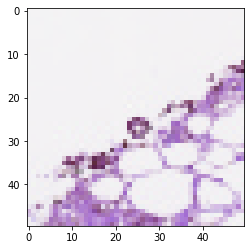

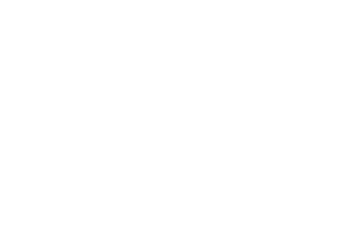

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

DATADIR = r"/content/10264"
CATEGORIES = ["0","1"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        plt.axis("off")
        break
    break

In [ ]:
img_array.shape



(50, 50, 3)

In [ ]:
from numpy import asarray

pixels = asarray(img_array)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 48.000, Max: 244.000
Min: 0.188, Max: 0.957


In [ ]:
#calculates the global mean and standard deviation pixel values, standardizes the pixel values,
#then confirms the transform by reporting the new global mean and standard deviation of 0.0 and 1.0 respectively.

pixels = asarray(img_array)
# convert from integers to floats
pixels = pixels.astype('float32')
# calculate global mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
pixels = (pixels - mean) / std
# confirm it had the desired effect
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

Mean: 185.263, Standard Deviation: 33.268
Mean: 0.000, Standard Deviation: 1.000


(-0.5, 149.5, 149.5, -0.5)

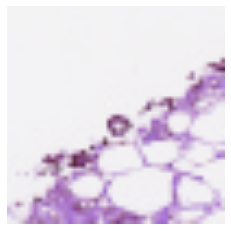

In [ ]:
IMG_SIZE = 50;
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))    
plt.imshow(new_array,cmap = "gray")
plt.axis("off")


In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [ ]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,150,150,1)

(1204, 150, 150)


In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
y = to_categorical(y, num_classes = 2)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (963, 150, 150, 1)
x_test shape (241, 150, 150, 1)
y_train shape (963, 4)
y_test shape (241, 4)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)  


In [ ]:
epochs = 40  
batch_size = 24

In [ ]:
datagen.fit(X_train)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size)    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/40
24/24 [==============================] - 117s 5s/step - loss: 0.8276 - accuracy: 0.4865 - val_loss: 0.9694 - val_accuracy: 0.4274
Epoch 2/40
24/24 [==============================] - 111s 5s/step - loss: 0.6739 - accuracy: 0.5504 - val_loss: 0.8543 - val_accuracy: 0.4274
Epoch 3/40
24/24 [==============================] - 111s 5s/step - loss: 0.4969 - accuracy: 0.8277 - val_loss: 1.4134 - val_accuracy: 0.4274
Epoch 4/40
24/24 [==============================] - 110s 5s/step - loss: 0.3464 - accuracy: 0.8765 - val_loss: 1.0824 - val_accuracy: 0.5602
Epoch 5/40
24/24 [==============================] - 110s 5s/step - loss: 0.3103 - accuracy: 0.8971 - val_loss: 1.4675 - val_accuracy: 0.4647
Epoch 6/40
24/24 [==============================] - 113s 5s/step - loss: 0.2829 - accuracy: 0.9101 - val_loss: 1.3255 - val_accuracy: 0.5643
Epoch 7/40
24/24 [==============================] - 113s 5s/step - loss: 0.4663 - accuracy: 0.7551 - val_loss: 1.2633 - val_accuracy: 0.5145
Epoch 8/40
24

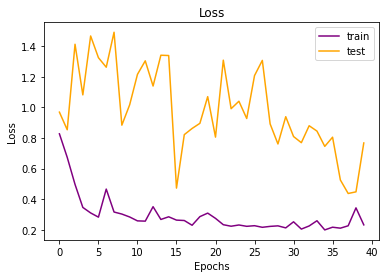

In [ ]:
plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

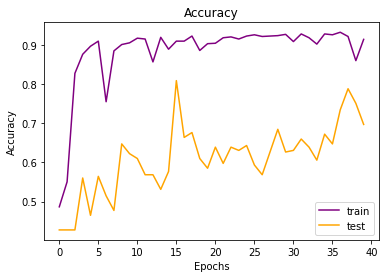

In [ ]:
plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
pred = model.predict(X_val)
print(pred[0:3,:])

[[1.3112086e-01 8.6876273e-01 6.6080691e-05 5.0372226e-05]
 [5.8978951e-01 4.0967366e-01 2.7399848e-04 2.6287677e-04]
 [5.0559822e-02 9.4942760e-01 6.8736822e-06 5.6617778e-06]]


In [ ]:
temp = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)
pred[np.arange(pred.shape[0]), temp] = 1
print(pred[0:3,:])
print(Y_val[0:3,:])

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(Y_val, pred)))
print(classification_report(Y_val, pred, target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

Accuracy : 0.6970954356846473
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.49      0.65       138
meningioma_tumor       0.59      0.98      0.73       103
        no_tumor       0.00      0.00      0.00         0
 pituitary_tumor       0.00      0.00      0.00         0

       micro avg       0.70      0.70      0.70       241
       macro avg       0.39      0.37      0.35       241
    weighted avg       0.81      0.70      0.68       241
     samples avg       0.70      0.70      0.70       241



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_val, Y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 69.71%
